# Imports

In [187]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import numpy as np
import copy
import time
import snakeviz
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import random
from sklearn.datasets import load_diabetes
assert pyro.__version__.startswith('1.8.4')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Load Datasets

### Random Dataset

In [188]:
def generate_stdp_dataset(dim, num_examples, min_value, max_value):
    X = np.random.random((num_examples + 1, dim)) * (max_value - min_value) + min_value
    beta = np.random.random((dim)) * (max_value - min_value) + min_value

    noise = np.random.normal(0, np.sqrt(max_value - min_value), num_examples + 1)
    Y = X[:num_examples + 1] @ beta + noise

    X = np.asfortranarray(X)
    Y = np.asfortranarray(Y)
    X /= np.linalg.norm(X, axis=0)
    Y = (Y - Y.mean()) / Y.std()
    Y = Y * max_value

    Y = Y/np.linalg.norm(Y)

    return X, Y, beta

In [189]:
X, Y, beta = generate_stdp_dataset(10, 442, 0, 1)

### Diabetes Dataset

X, Y = load_diabetes(return_X_y = True)

print(Y[0:3])
Y = (Y - Y.mean()) / Y.std()
print(Y[0:3])
X = X / np.linalg.norm(X)
print(X[0:3])

In [190]:
print(X)
print(Y)

[[0.00561282 0.06082592 0.02156838 ... 0.07802452 0.03633695 0.03362975]
 [0.000233   0.06210752 0.02815031 ... 0.02293757 0.07352793 0.00964205]
 [0.05718343 0.04962301 0.05925292 ... 0.05748705 0.06020583 0.06923634]
 ...
 [0.05479487 0.00682738 0.04542745 ... 0.06556626 0.044984   0.05443746]
 [0.05258681 0.03120526 0.02851217 ... 0.06054289 0.01872964 0.02592906]
 [0.02002188 0.04966799 0.01877354 ... 0.06236154 0.03172936 0.03697273]]
[ 5.16588960e-02 -9.14983851e-02 -1.20201899e-02 -3.45136761e-02
  2.02948996e-02  8.72682894e-02  3.25098100e-02  4.77639565e-02
 -4.13571891e-02  5.28840213e-02 -5.77765435e-02  8.31430833e-02
 -9.67235554e-02  8.84555578e-03 -8.10329796e-02  3.07044224e-02
 -2.93058485e-03  1.80136747e-02 -8.16805652e-02 -3.67532272e-02
 -2.35135826e-02 -1.83812232e-02  3.83151071e-02 -2.06728823e-02
  2.79844917e-02  2.38419675e-02 -8.10797126e-02 -6.61011257e-02
  3.26733995e-02  4.92200219e-02 -3.86764175e-02 -3.42485726e-02
  1.11714005e-02  1.75137499e-03 -1.

In [191]:
print(len(X[0]))

10


### Set up X, Y train

In [192]:
X_train = copy.deepcopy(X)
Y_train = copy.deepcopy(Y[:len(Y) - 1])
X_train = [torch.tensor(member) for member in X_train]
Y_train = [torch.tensor(member) for member in Y_train]
dim = len(X[0])

In [193]:
np.std(Y_train)

0.04755704892321442

# Model and Guide Setup

In [194]:
global prev_mu_q

prev_mu_q = torch.zeros(dim, dtype=torch.float64)

In [195]:
std0 = torch.eye(dim, dtype=torch.float64) * 0.3
def model(data):
    # define the hyperparameters that control the Beta prior
    mu0 = torch.zeros(dim, dtype=torch.float64)
    std0 = torch.eye(dim, dtype=torch.float64) * 0.3
    # sample f from the Beta prior
    std = pyro.sample("sigma", dist.HalfNormal(1))

    f = pyro.sample("latent_fairness", dist.MultivariateNormal(mu0, std0))
    # loop over the observed data
    # int(len(data) / dim) was using this as sample count
    subset = random.sample(data, 200)
    for i in range(len(subset)):
        pyro.sample("obs_{}".format(i), dist.Normal(f.dot(subset[i][0]), std), obs=subset[i][1])
        
def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    mu_q = pyro.param("mu_q", copy.deepcopy(prev_mu_q))
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.MultivariateNormal(mu_q, std0))

In [196]:
def train_SVI(D_hat, n_steps, prev_mu_q = None):
    # setup the optimizer
    adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # setup the inference algorithm
    guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
#     if prev_mu_q is not None:
#         print(guide.state_dict().keys())
#         guide.state_dict()["loc"][0:10] = prev_mu_q
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    losses = []
    # do gradient steps
    for step in range(n_steps):
        loss = svi.step(D_hat)
        losses.append(loss)
        if loss < 1e-5:
            break
    
    mu_q = guide.state_dict()["loc"]
    return mu_q[0:10], losses

# Run VI on Data 

In [197]:
all_losses = []

In [198]:
rank_proportions = []
y_hat = max(Y_train)
y_bottom = min(Y_train)
print(y_hat)
print(y_bottom)
conformal_set = []
decrease_size = 0.01
start = time.time()
print(max(Y_train))
print(min(Y_train))
prev_mu_q = None
while y_hat >= y_bottom:
    pyro.clear_param_store()
    # Create D_hat
    D_hat = list(zip(X_train[:-1], Y_train))
    D_hat.append((X_train[-1], y_hat))
    
    # Train SVI
    mu_q, losses = train_SVI(D_hat, 5, prev_mu_q)
    all_losses.append(losses)
    prev_mu_q = copy.deepcopy(mu_q)
    
    # Calculate rank of y_hat
    rank = [(abs(sum(D_hat[i][0] * mu_q) - D_hat[i][1]).detach().numpy()) for i in range(len(D_hat))]
    y_hat_rank = rank[-1]
    
    # Add to conformal set if in not in bottom 10 percent of probabilities
    current_rank_proportion = np.count_nonzero(y_hat_rank > rank) / len(rank)
    rank_proportions.append(current_rank_proportion)
    if current_rank_proportion < 0.8:
        conformal_set.append(copy.deepcopy(y_hat))
        print(f"{y_hat} Added")
    else:
        print(f"{y_hat} Not added")
    y_hat -= decrease_size
conformal_set = [min(conformal_set), max(conformal_set)]
end = time.time()

tensor(0.1434, dtype=torch.float64)
tensor(-0.1338, dtype=torch.float64)
tensor(0.1434, dtype=torch.float64)
tensor(-0.1338, dtype=torch.float64)
0.14340204566599066 Not added
0.13340204566599065 Not added
0.12340204566599065 Not added
0.11340204566599066 Not added
0.10340204566599066 Not added
0.09340204566599067 Not added
0.08340204566599067 Not added
0.07340204566599068 Not added
0.06340204566599068 Not added
0.05340204566599068 Added
0.04340204566599068 Added
0.03340204566599068 Added
0.023402045665990676 Added
0.013402045665990675 Added
0.003402045665990675 Added
-0.006597954334009325 Added
-0.016597954334009325 Added
-0.026597954334009327 Added
-0.03659795433400933 Added
-0.04659795433400933 Added
-0.05659795433400933 Added
-0.06659795433400933 Added
-0.07659795433400933 Not added
-0.08659795433400932 Added
-0.09659795433400932 Added
-0.10659795433400931 Not added
-0.11659795433400931 Not added
-0.1265979543340093 Not added


In [199]:
print(f"Conformal Set: [{float(conformal_set[0])}, {float(conformal_set[1])}]")
print(f"Length: {float(conformal_set[1] - conformal_set[0])}")
print(f"Y[-1]: {Y[-1]}")
if Y[-1] >= conformal_set[0] and Y[-1] <= conformal_set[1]:
    print(f"Y[-1] is covered")
else:
    print("Y[-1] is Not covered")
print(f"Elapsed Time: {end - start}")

Conformal Set: [-0.09659795433400932, 0.05340204566599068]
Length: 0.15
Y[-1]: 0.018433892501499485
Y[-1] is covered
Elapsed Time: 10.702775001525879


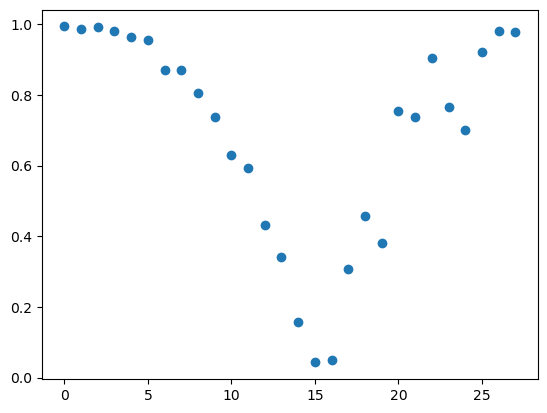

In [200]:
import matplotlib.pyplot as plt
plt.scatter(range(len(rank_proportions)), rank_proportions)

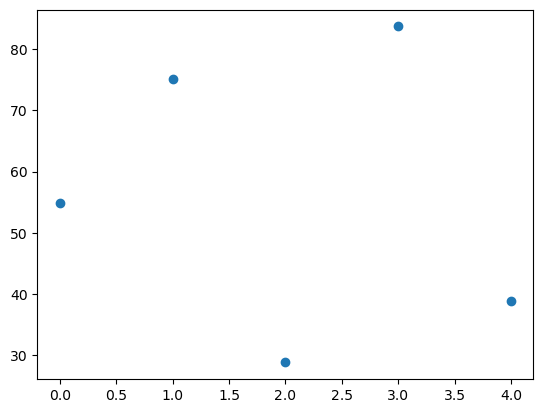

In [201]:
import matplotlib.pyplot as plt
plt.scatter(range(len(all_losses[0])), all_losses[0])
plt.show()

In [202]:
print(svi.state_dict())

NameError: name 'svi' is not defined

In [ ]:
mu_q